# Regression Kriging Model

## setup

In [1]:
# default libs
import os, sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# vector geo data libs
import pandas as pd
import geopandas as gpd
import contextily as cx
pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 500)
# kriging
from pykrige.rk import RegressionKriging
import pykrige.kriging_tools as kt
# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error, r2_score
from itertools import product
import re
from tqdm.notebook import tqdm
import random


In [2]:
# importing datasets
data_lu = gpd.read_file('..\\output\\data_lu_nr2.GEOJSON', engine='pyogrio')
data_sp = gpd.read_file('..\\output\\data_sp_nr2.GEOJSON', engine='pyogrio')
data_oz = gpd.read_file('..\\output\\data_oz_nr2.GEOJSON', engine='pyogrio')
x_cols = ['maxspeed', 'bridge',
       'junction', 'rt_highway', 'rt_trunk', 'rt_primary', 'rt_secondary',
       'rt_tertiary', 'rt_unclassified', 'rt_residential', 'rt_living_street',
       'rt_busway', 'rt_service', 'dist_to_train', 'dist_to_recreation',
       'landuse_is_residential', 'landuse_is_commercial',
       'landuse_is_industrial', 'building_height']

## Baseline Models

## Model Selection 

### Spatial K-Fold Setup

In [14]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

class pykrige_tuning_results():
    def __init__(self, score_overview, model):
        score_overview = dict(sorted(score_overview.items(), key=lambda s: s[1]))
        self.score_overview = score_overview
        self.best_score = float(list(score_overview.values())[0])
        
        self.best_model_params = list(score_overview.keys())[0][0]
        self.best_model_params = self._recover_param_dict(self.best_model_params)
        self.best_krige_params = list(score_overview.keys())[0][1]
        self.best_krige_params = self._recover_param_dict(self.best_krige_params)

        self.model = model

    def _recover_value(self, v):
        if all([c in "0123456789" for c in v]): return int(v)
        if all([c in "0123456789." for c in v]): return float(v)
        if v == 'None': return None
        return v

    def _recover_param_dict(self, s):
        r = re.findall(r"'([\w\d_]*)', ('?[\w\d_]*'?)", s)
        return {k: self._recover_value(v) for (k,v) in r}

    def get_optimal_model(self):
        m = self.model(**self.best_model_params)
        rk_m = RegressionKriging(m, **self.best_krige_params)
        return rk_m
        


class pykrige_rk_tuner():
    """
    Provides an adapted kfold-tuning routine for use with pykrige. Makes several
    assumptions likely specific to this application.
    """
    def __init__(self, data, x_cols, y_col, c_cols=['x', 'y'], fold_col='fold', scorer=root_mean_squared_error):
        self.data = data
        self.x_cols = x_cols
        self.y_col = y_col
        self.c_cols = c_cols
        self.fold_col = fold_col
        self.scorer = scorer

        self.fold_values = self.data[self.fold_col].unique()

    def create_param_dicts_from_grid(self, grid):
        keys = grid.keys()
        values = grid.values()
        combinations = list(product(*values))
        return [dict(zip(keys, combination)) for combination in combinations]

    def tune(self, model, model_param_grid, krige_param_grid):
        """Custom tuning function for pykrige
        
        args:
        ----------
        model: 
            ML model from sklearn (as per pykrige docs)
        model_param_grid: 
            A dict with (k,v)=(parameter_name:[param_values]), with parameters for the sklearn model. 
            Each possible combination is tested.
        krige_param_grid: 
            A dict with (k,v)=(parameter_name:[param_values]), with parameters for the regression kriging model. 
            Each possible combination is tested.
        """
        model_param_dicts = self.create_param_dicts_from_grid(model_param_grid) 
        krige_param_dicts = self.create_param_dicts_from_grid(krige_param_grid)
        score_overview = {}

        tq = tqdm(total=len(model_param_dicts)*len(krige_param_dicts))
        for m_params in model_param_dicts:
            for k_params in krige_param_dicts:

                scores = []
                for fold in self.fold_values: 
                    X_train = self.data[self.data[self.fold_col] != fold][self.x_cols].values
                    c_train = self.data[self.data[self.fold_col] != fold][self.c_cols].values
                    y_train = self.data[self.data[self.fold_col] != fold][self.y_col].values

                    X_test = self.data[self.data[self.fold_col] == fold][self.x_cols].values
                    c_test = self.data[self.data[self.fold_col] == fold][self.c_cols].values
                    y_test = self.data[self.data[self.fold_col] == fold][self.y_col].values
                    
                    m = model(**m_params)
                    m_rk = RegressionKriging(regression_model=m, verbose=False, **k_params)
                    with HiddenPrints():
                        m_rk.fit(X_train, c_train, y_train)
                    y_pred = m_rk.predict(X_test, c_test)
                    scores.append(self.scorer(y_pred, y_test))
                score_overview[(str(m_params.items()), str(k_params.items()))] = np.mean(scores)
                tq.update()
                    
        return pykrige_tuning_results(score_overview, model)
      
# creating spatial groups/clusters within each dataset
def add_spatial_fold_groups(gdf, x_col='x', y_col='y', group_col='fold'):
    """ Adds a column with a group_id to the df/gdf, with each group
    being a cluster of points of roughly the same size. Useful for
    spatial k-fold. Creates a total of 16 groups.
    """ # TODO might create better splits using sort -> .iloc splits (will be less efficient though)
    gdf[group_col] = -1
    s2 = gdf[x_col].median() # create a split on x
    s1, s3 = gdf[gdf[x_col] < s2][x_col].median(), gdf[gdf[x_col] >= s2][x_col].median()
    group_id = 0
    pxs = -np.inf
    for xs in (s1, s2, s3, np.inf):
        g = gdf[gdf[x_col] < xs]
        ys2 = g[y_col].median() # for each x split, create a split on y
        ys1, ys3 = g[g[y_col] < ys2][y_col].median(), g[g[y_col] >= ys2][y_col].median()
        pys = -np.inf
        for ys in (ys1, ys2, ys3, np.inf): # for each split assign group_id
            gdf.loc[(pxs < gdf[x_col]) & (gdf[x_col] <= xs) & 
                    (pys < gdf[y_col]) & (gdf[y_col] <= ys), group_col] = group_id
            pys = ys; group_id += 1
        pxs = xs
    return gdf

def get_test_folds(df, target_ratio=0.3, return_train_folds=False, fold_col='fold', random_seed=None):
    if random_seed: random.seed(random_seed)

    folds = df[fold_col].unique()
    selected_folds, ratio = [], 0

    while ratio < target_ratio-0.02:
        sel_f = random.choice(folds)
        if sel_f in selected_folds: continue
        selected_folds.append(sel_f)
        ratio += df[df['fold'] == sel_f].shape[0] / df.shape[0]
    if return_train_folds:
        return np.sort(selected_folds), np.setdiff1d(folds, selected_folds)
    return np.sort(selected_folds)

In [15]:
# seperating each area into folds
data_lu = add_spatial_fold_groups(data_lu.reset_index())
data_sp = add_spatial_fold_groups(data_sp.reset_index())
data_oz = add_spatial_fold_groups(data_oz.reset_index())
# for each area make rows & folds recognisable
data_lu['location'] = 'Lunetten'
data_oz['location'] = 'Oud Zuilen'
data_sp['location'] = 'Science Park'
data_lu['fold'] += 300
data_oz['fold'] += 200
data_sp['fold'] += 100
# combine into single gdf
data_full = pd.concat((data_sp, data_oz, data_lu))
data_nans = data_full[data_full['dBA_reg'].isna()]
data_full = data_full[data_full['dBA_reg'].notna()]

### Optimising potential models

In [16]:
# setup for hyper parameter tuning RegressionKriging
test_folds, train_folds = get_test_folds(data_full, return_train_folds=True, random_seed=2)

kriging_param_grid = {
    'n_closest_points': [20, 40, 60] ,
    'nlags': [5, 10, 20]
}

rk_tuner = pykrige_rk_tuner(data=data_full[data_full['fold'].isin(train_folds)], 
                               x_cols=x_cols, y_col='dBA_reg')

# garbage function do not reuse
def test_results(tuning_results):
    m = tuning_results.get_optimal_model()
    m.fit(data_full[data_full['fold'].isin(train_folds)][x_cols].values,
          data_full[data_full['fold'].isin(train_folds)][['x','y']].values,
          data_full[data_full['fold'].isin(train_folds)]['dBA_reg'].values)
    p = m.predict(data_full[data_full['fold'].isin(test_folds)][x_cols].values,
              data_full[data_full['fold'].isin(test_folds)][['x','y']].values,)
    print(f'R2: {r2_score(data_full[data_full['fold'].isin(test_folds)]['dBA_reg'].values, p)}')
    print(f'RMSE: {root_mean_squared_error(data_full[data_full['fold'].isin(test_folds)]['dBA_reg'].values, p)}')
    return p


<!-- this is so sad.
Alexa,
play despacito -->

In [17]:
# Linear Regression - Baseline
lr_param_grid = {}

lr_tune_results = rk_tuner.tune(LinearRegression, lr_param_grid, kriging_param_grid)
test_results(lr_tune_results)

  0%|          | 0/9 [00:00<?, ?it/s]

Finished learning regression model
Finished kriging residuals
R2: 0.22848973934387073
RMSE: 4.406148810658107


array([58.23232512, 58.27044086, 58.29015008, 58.31026988, 58.71529505,
       58.49383266, 58.49826066, 58.0168537 , 58.11804819, 58.02611153,
       58.02759006, 58.14650258, 58.52445193, 58.53395555, 57.91718768,
       58.07389031, 58.08880546, 58.21688716, 58.05283162, 58.18699122,
       58.33852453, 58.2098052 , 58.16041689, 58.33655653, 58.66393114,
       58.31015577, 58.64687018, 58.66425723, 58.77954218, 58.65710898,
       58.46906242, 58.39399519, 58.52830224, 58.43437539, 58.42708448,
       58.47498334, 58.24910487, 58.24518059, 58.22944594, 58.23570741,
       59.47826584, 59.47826584, 57.87499715, 57.95487756, 57.86035009,
       57.58721416, 57.79039834, 61.54472666, 61.54472666, 57.75075919,
       58.10784336, 57.92103332, 58.31080841, 58.26705202, 62.50896054,
       62.50896054, 58.45376922, 62.62148548, 62.62148548, 58.37782102,
       58.36405772, 58.4141834 , 58.8532879 , 58.42962343, 58.42951319,
       63.09141395, 58.84206563, 58.42033512, 58.42158184, 58.84

In [ ]:
# Stochastic Gradient Descent (SGD)
from sklearn.linear_model import SGDRegressor
sgd_tune_results = rk_tuner.tune(SGDRegressor,
                                model_param_grid={
                                    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0],
                                    'penalty': ['l2', 'l1', 'elasticnet'],
                                    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive']
                                },
                                krige_param_grid=kriging_param_grid)
test_results(sgd_tune_results)
# ! linalg solve errors

In [72]:
# Gradient Boosting (GB)
gb_tune_results = rk_tuner.tune(GradientBoostingRegressor,
                                model_param_grid={
                                    'n_estimators': [100],
                                    'learning_rate': [0.01, 0.1, 0.2, 0.3],
                                    # 'max_depth': [3, 5, 7],
                                    'min_samples_leaf': [20, 40, 80],
                                    # 'max_features': [2,6,10],
                                    'random_state':[2]
                                },
                                krige_param_grid=kriging_param_grid)

print(f"best model params: {gb_tune_results.best_model_params}")
print(f"best krige params: {gb_tune_results.best_krige_params}")
test_results(gb_tune_results)

  0%|          | 0/108 [00:00<?, ?it/s]

best model params: {'n_estimators': 100, 'learning_rate': 0, 'min_samples_leaf': 40, 'random_state': 2}
best krige params: {'n_closest_points': 60, 'nlags': 5}
Finished learning regression model
Finished kriging residuals
R2: 0.1164932079961214
RMSE: 4.692002372339051


In [63]:
rf_tune_results = rk_tuner.tune(RandomForestRegressor, 
                                model_param_grid={
                                    'n_estimators': [50, 100, 200],
                                    'min_samples_leaf': [20, 40, 80],
                                    'random_state': [2]
                                }, 
                                krige_param_grid=kriging_param_grid)
test_results(rf_tune_results)

  0%|          | 0/81 [00:00<?, ?it/s]

Finished learning regression model
Finished kriging residuals
R2: 0.26330929813800785
RMSE: 4.284457813923993


## Visualise model results

<Axes: >

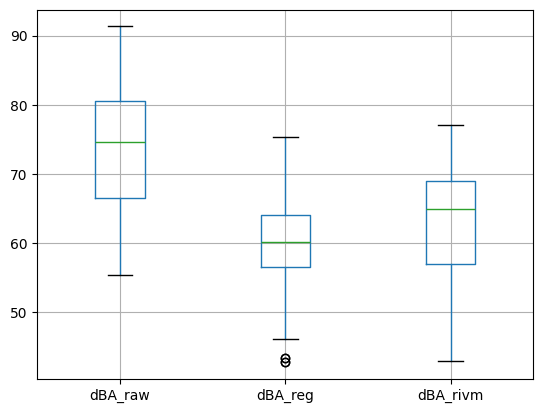

In [8]:
data_full.boxplot(column=['dBA_raw', 'dBA_reg', 'dBA_rivm'])

In [13]:
lr_tune_results.best_krige_params

{'n_closest_points': 60.0, 'nlags': 20.0}

Finished learning regression model
Finished kriging residuals


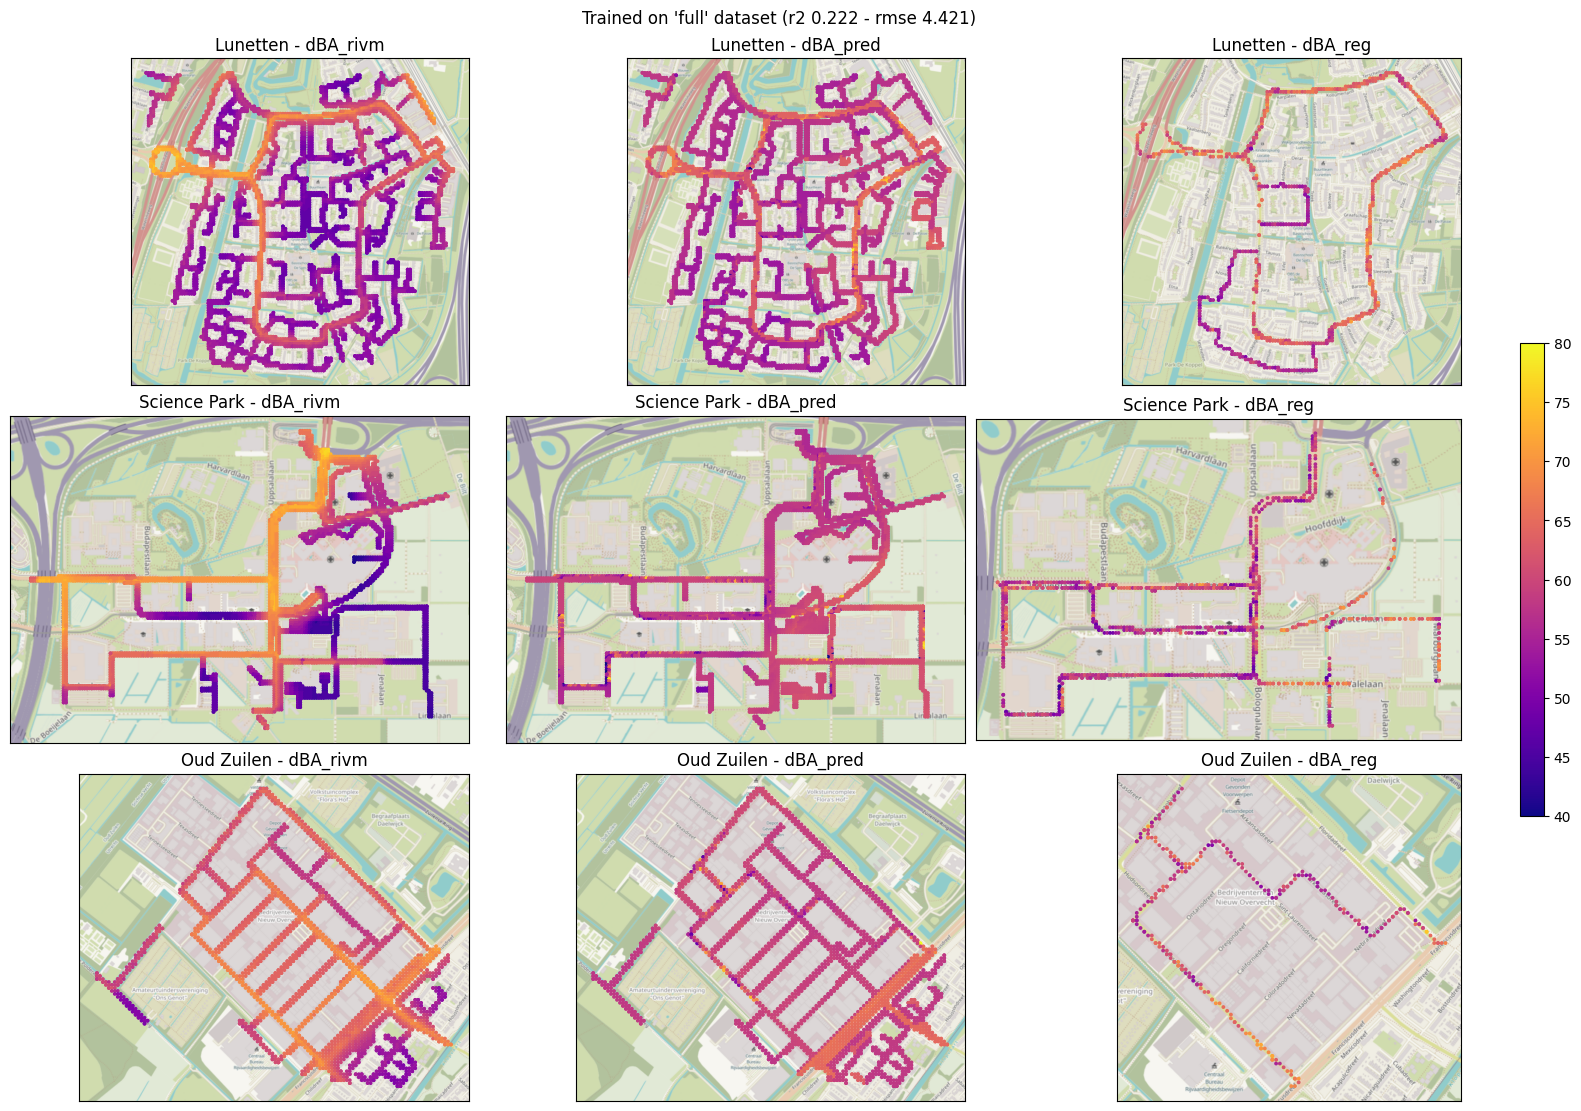

In [34]:
def vis_model_results(df, full_df, model, training_region='full'):
    if training_region != 'full':
        model.fit(df[df['location'] == training_region][x_cols].values,
                df[df['location'] == training_region][['x','y']].values,
                df[df['location'] == training_region]['dBA_reg'].values)
    else:
        model.fit(df[df['fold'].isin(train_folds)][x_cols].values,
                df[df['fold'].isin(train_folds)][['x','y']].values,
                df[df['fold'].isin(train_folds)]['dBA_reg'].values)
    y_test = model.predict(df[df['fold'].isin(test_folds)][x_cols].values, 
            df[df['fold'].isin(test_folds)][['x','y']].values)
    y_true = df[df['fold'].isin(test_folds)]['dBA_reg'].values
    r2 = r2_score(y_true, y_test)
    rmse = root_mean_squared_error(y_true, y_test)
    full_df['dBA_pred'] = model.predict(full_df[x_cols].values, full_df[['x','y']].values)

    fig, axs = plt.subplots(3,3, figsize=(16,11), layout="constrained")
    norm, cmap = mpl.colors.Normalize(vmin=40, vmax=80), 'plasma'
    for x, dBA in enumerate(('dBA_rivm', 'dBA_pred', 'dBA_reg')):
        for y, region in enumerate(('Lunetten', 'Science Park', 'Oud Zuilen')):
            full_df[full_df['location']==region].plot(column=dBA, ax=axs[y][x], markersize=3, norm=norm, cmap=cmap)
            axs[y][x].set_xticks([]); axs[y][x].set_yticks([])
            axs[y][x].set_title(f"{region} - {dBA}")
            # axs[y][x].set_ylabel(f"")
            cx.add_basemap(axs[y][x], crs=full_df.crs, attribution=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, fraction=0.016, pad=0.04)
    fig.suptitle(f"Trained on '{training_region}' dataset (r2 {r2:.3f} - rmse {rmse:.3f})")
    return fig

vis_model_results(data_full, pd.concat((data_full, data_nans)), lr_tune_results.get_optimal_model())
    # 1 vis takes like a whole minute

Finished learning regression model
Finished kriging residuals


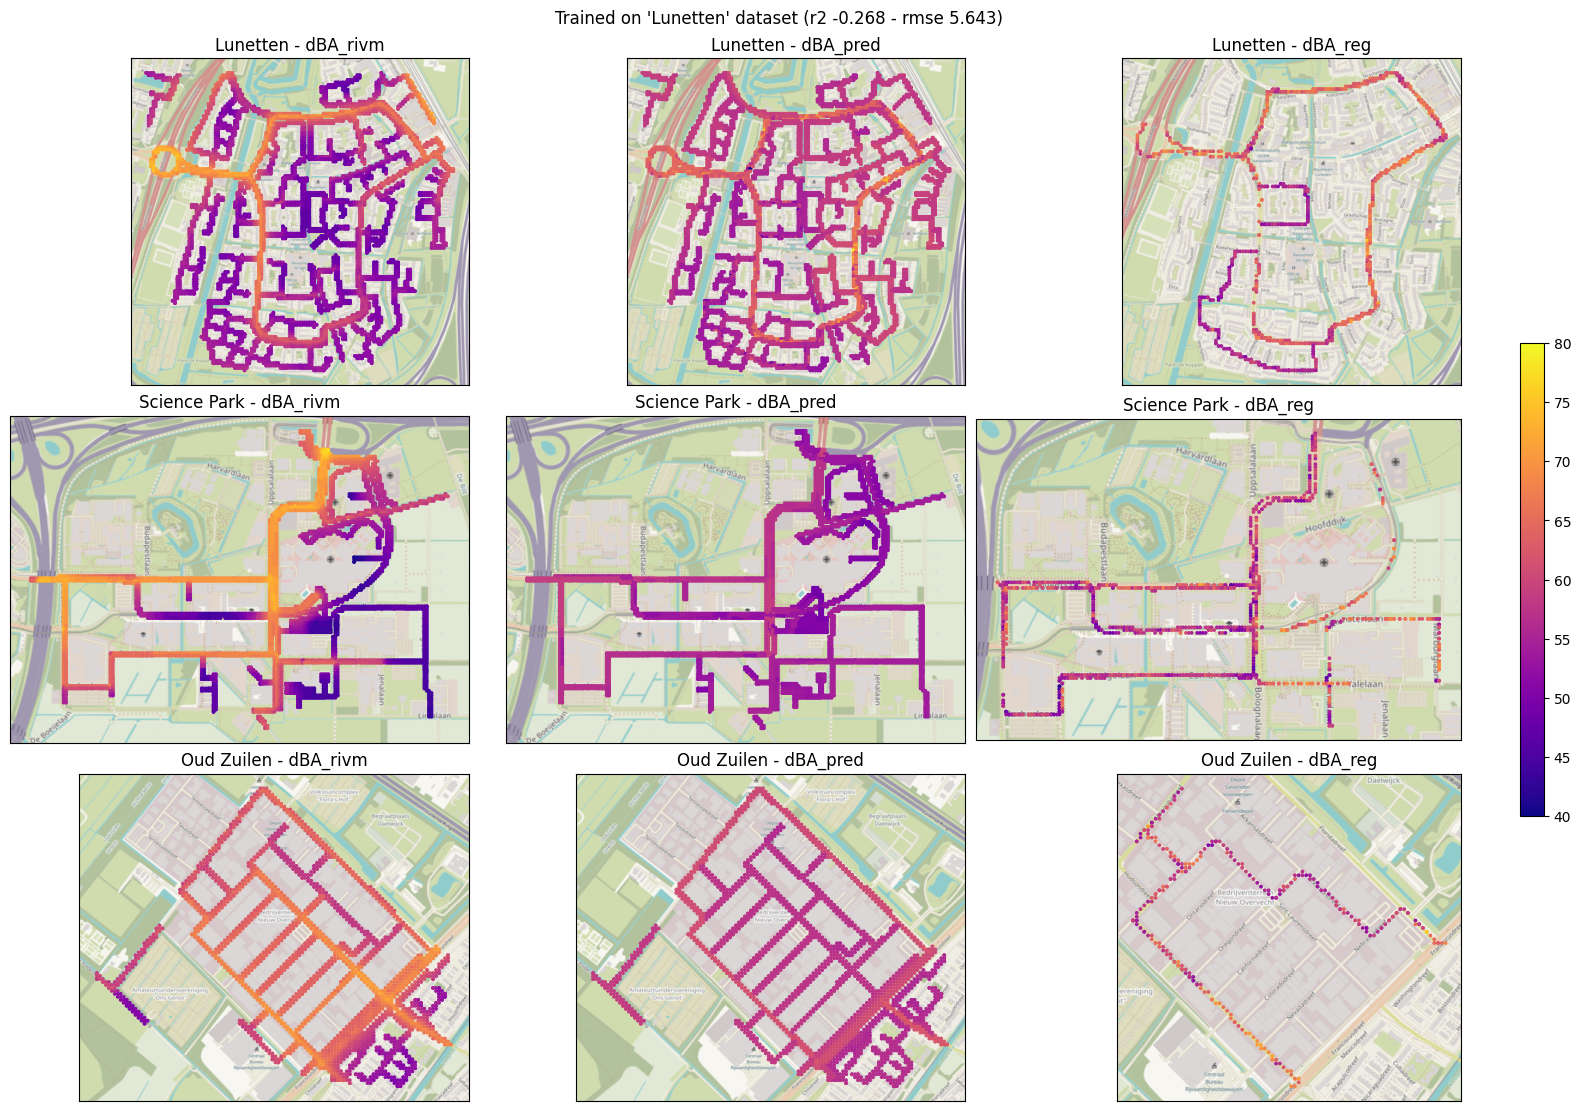

In [36]:
vis_model_results(data_full, pd.concat((data_full, data_nans)), lr_tune_results.get_optimal_model(), training_region='Lunetten')

In [78]:
data_full

,index,x,y,dBA_raw,dBA_reg,dBA_rivm,maxspeed,bridge,junction,rt_highway,rt_trunk,rt_primary,rt_secondary,rt_tertiary,rt_unclassified,rt_residential,rt_living_street,rt_busway,rt_service,dist_to_train,dist_to_recreation,landuse_is_residential,landuse_is_commercial,landuse_is_industrial,building_height,geometry,fold,location
64,64,140775.0,455895.0,67.641683,62.652329,77,80,False,True,False,False,True,False,False,False,False,False,False,False,2811.359001,328.076765,False,False,False,0.00,POINT (140775.000 455895.000),111,Science Park
75,75,140765.0,455885.0,68.238085,59.190047,75,80,False,False,False,False,False,True,False,False,False,False,False,False,2803.753244,318.347461,False,False,False,0.00,POINT (140765.000 455885.000),111,Science Park
76,76,140775.0,455885.0,71.295291,64.984505,76,80,False,False,False,False,False,True,False,False,False,False,False,False,2813.513744,328.338617,False,False,False,0.00,POINT (140775.000 455885.000),111,Science Park
88,88,140765.0,455875.0,70.725506,58.409247,74,50,False,False,False,False,False,True,False,False,False,False,False,False,2805.949466,318.931010,False,False,False,0.00,POINT (140765.000 455875.000),111,Science Park
89,89,140775.0,455875.0,76.001737,69.164972,74,80,False,False,False,False,False,False,False,False,False,False,True,False,2815.702352,328.904440,False,False,False,0.00,POINT (140775.000 455875.000),111,Science Park
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6369,6369,137705.0,452155.0,70.420346,61.935185,52,30,False,False,False,False,False,False,False,False,True,False,False,False,1442.193165,191.379187,True,False,False,12.37,POINT (137705.000 452155.000),304,Lunetten
6370,6370,137705.0,452155.0,70.420346,61.935185,52,30,False,False,False,False,False,False,False,False,True,False,False,False,1442.193165,191.379187,True,False,False,12.37,POINT (137705.000 452155.000),304,Lunetten
6371,6371,137715.0,452155.0,69.366135,62.352511,53,30,False,False,False,False,False,False,False,False,True,False,False,False,1438.089301,187.687408,True,False,False,12.37,POINT (137715.000 452155.000),308,Lunetten
6372,6372,137715.0,452155.0,69.366135,62.352511,53,30,False,False,False,False,False,False,False,False,True,False,False,False,1438.089301,187.687408,True,False,False,12.37,POINT (137715.000 452155.000),308,Lunetten
